<a href="https://colab.research.google.com/github/JRaidal/Defect-Tracker/blob/main/Machine_Learning_Topological_Defects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Topological Defects



#Mount Google Drive to access analysis videos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install YOLOv5 and Dependencies



In [2]:
# Clone YOLOv5 GIT repository

!git clone --recurse-submodules https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch.git

Cloning into 'Yolov5_DeepSort_Pytorch'...
remote: Enumerating objects: 744, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 744 (delta 0), reused 1 (delta 0), pack-reused 741
Receiving objects: 100% (744/744), 25.68 MiB | 21.45 MiB/s, done.
Resolving deltas: 100% (338/338), done.
Submodule 'yolov5' (https://github.com/ultralytics/yolov5.git) registered for path 'yolov5'
Cloning into '/content/Yolov5_DeepSort_Pytorch/yolov5'...
remote: Enumerating objects: 7771, done.        
remote: Counting objects: 100% (83/83), done.        
remote: Compressing objects: 100% (47/47), done.        
remote: Total 7771 (delta 46), reused 59 (delta 36), pack-reused 7688        
Receiving objects: 100% (7771/7771), 9.34 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (5344/5344), done.
Submodule path 'yolov5': checked out 'b8be76f915207ef0759bfb0f1c0707c79877b763'


In [3]:
# Install dependencies based on requirements file.
!pip install -qr /content/Yolov5_DeepSort_Pytorch/requirements.txt


     |████████████████████████████████| 645kB 9.5MB/s 


# Import a Few More Required Packages and Check Hardware

In [5]:
%cd /content/Yolov5_DeepSort_Pytorch/yolov5
import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# Check GPU type given by Google Colab
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/content/Yolov5_DeepSort_Pytorch/yolov5
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. 

In [14]:
# Export Roboflow code snippet and paste here
%cd /content/Yolov5_DeepSort_Pytorch/
!curl -L "https://app.roboflow.com/ds/gWJK8Mqo5s?key=gwrAirRrq3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/Yolov5_DeepSort_Pytorch
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    601      0  0:00:01  0:00:01 --:--:--   601
100 15.4M  100 15.4M    0     0  9223k      0  0:00:01  0:00:01 --:--:--  299M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/5CB-Green_35-6-35-7C_heating_0-1Cmin00206_jpg.rf.56b475b3fdb19d98a9e735b199ba5e36.jpg  
 extracting: test/images/5CB-Green_35-6-35-7C_heating_0-1Cmin00208_jpg.rf.8e1a7b2c0d1bf84d59abbd5cafca8434.jpg  
 extracting: test/images/Nematic_defect-formation-3_Ingo_Dierking00043_jpg.rf.155795ebb51fe6afc328db3d4d0de966.jpg  
 extracting: test/images/Nematic_defect-formation-3_Ingo_Dierking00061_jpg.rf.559825065ef3bbfefce41ff6a50e9b0e.jpg  
 extracting: test/images/Nematic_defect-formati

In [15]:
# Check Roboflow YAML file.
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['4-fold defect', 'i']

# Define Model Configuration and Architecture

We will write a YALM script that defines the parameters for our model like the number of classes, anchors, and each layer.

We will be using the YOLOv5s architecture as our problem is not very complex (YOLOv5s is the smallest and fastest model of the YOLO family)

In [16]:
# Define number of object classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
# We will be using the YOLOv5s architecture
%cat /content/Yolov5_DeepSort_Pytorch/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [10]:
#Customize iPython writefile so we can write variables into YAML file
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/Yolov5_DeepSort_Pytorch/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Our YOLOv5 Detector

Here, we are able to pass a number of arguments:
- **img:** define input image size.
- **batch:** determine batch size.
- **epochs:** define the number of training epochs.
- **data:** set the path to our yaml file.
- **cfg:** specify our model configuration.
- **weights:** specify a custom path to starting weights.
- **name:** result names.
- **nosave:** only save the final checkpoint.
- **cache:** cache images for faster training.

In [17]:
# Train the model and time it.
%%time
%cd /content/Yolov5_DeepSort_Pytorch/yolov5/
#!python train.py --img 416 --batch 48 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights /content/Yolov5_DeepSort_Pytorch/yolov5/runs/train/yolov5s_results/weights/best.pt --name yolov5s_results  --cache
!python train.py --img 416 --batch 48 --epochs 300 --data '/content/data.yaml' --cfg /models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/Yolov5_DeepSort_Pytorch/yolov5
github: ⚠️ WARNING: code is out of date by 199 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v5.0-69-gb8be76f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=48, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='/content/data.yaml', device='', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=48, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorb

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.)

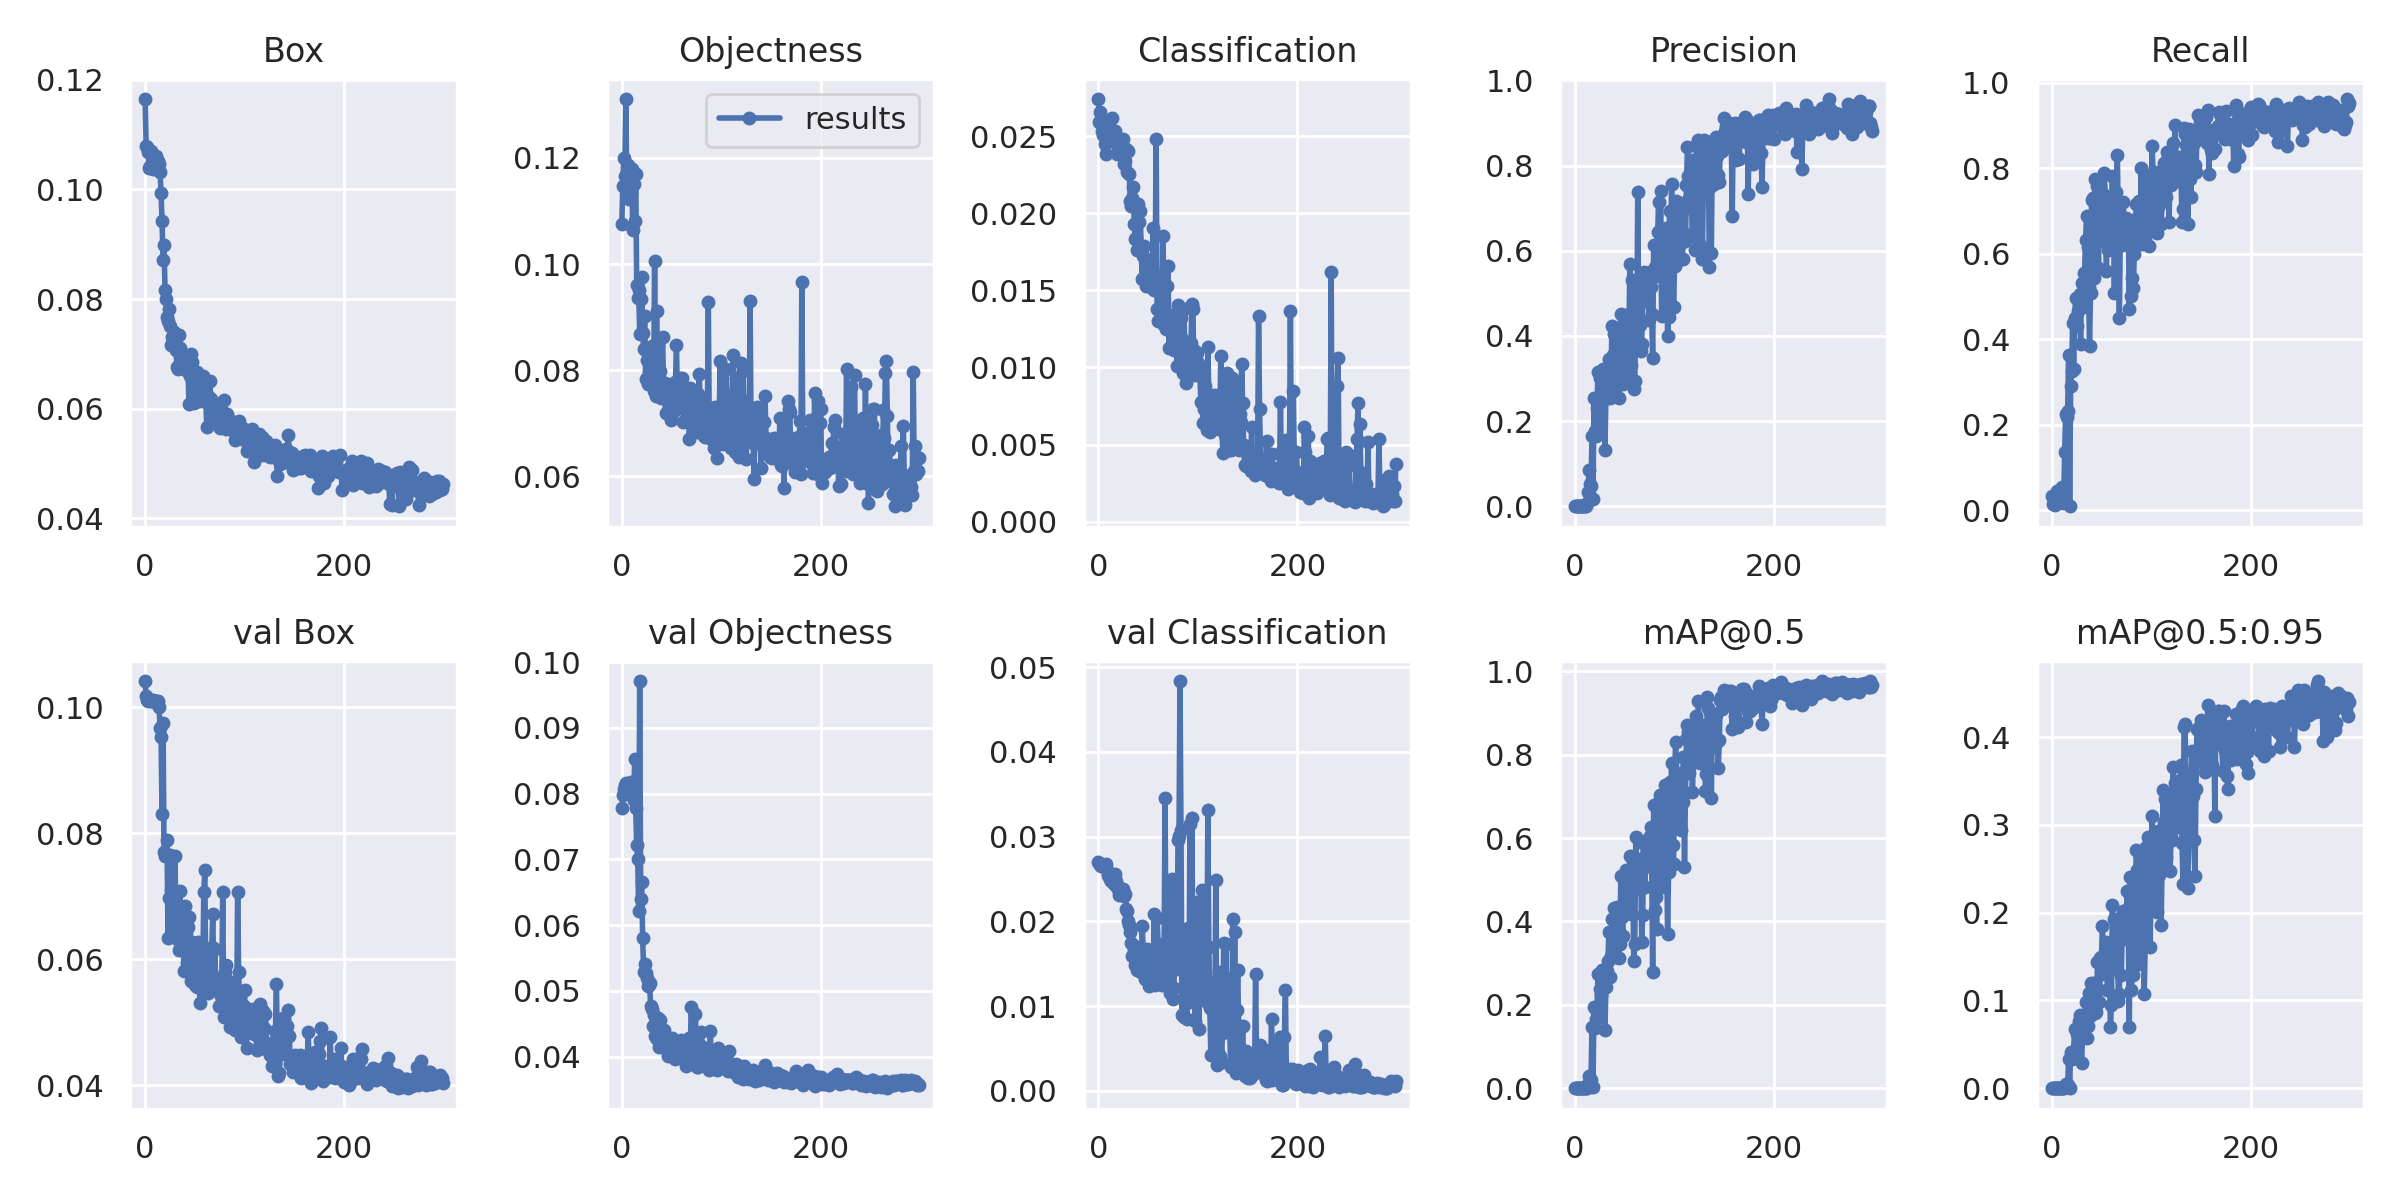

In [19]:
# Plot results using utils.plots
from utils.plots import plot_results
Image(filename='/content/Yolov5_DeepSort_Pytorch/yolov5/runs/train/yolov5s_results2/results.png', width=1000)

# Plotting Training Data.

As a sanity check, we display some training data images to check whether there is something wrong.

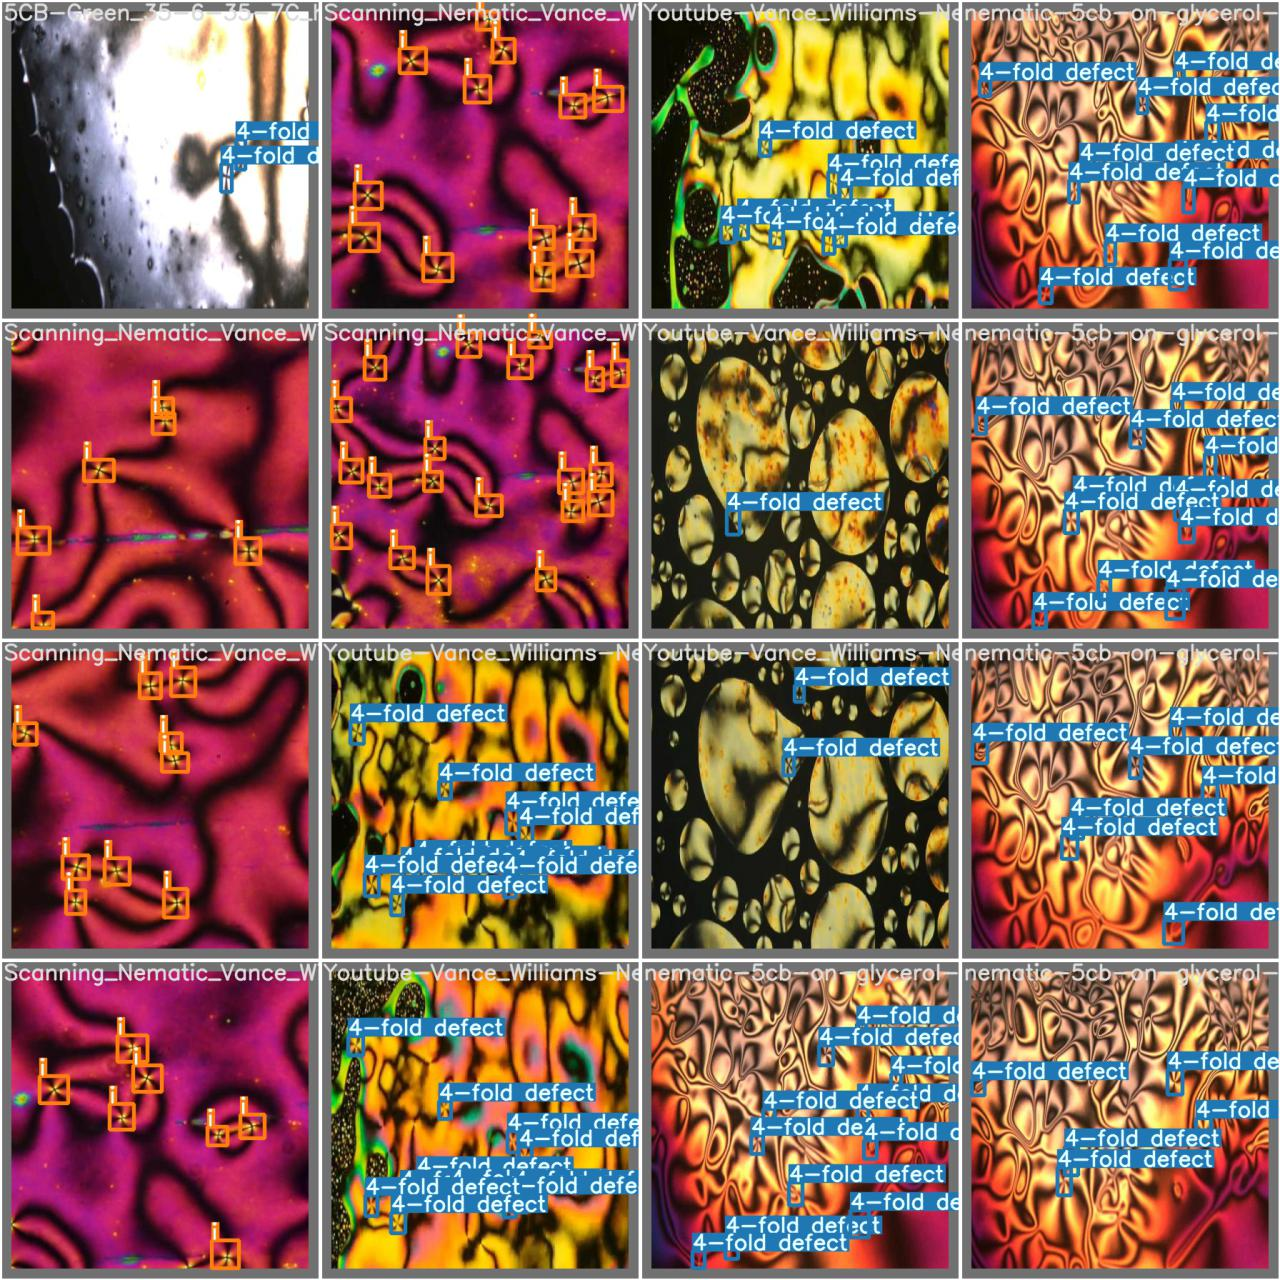

In [20]:
# Raw training data
Image(filename='/content/Yolov5_DeepSort_Pytorch/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [22]:
# Make sure to use correct trained weights!
%cd /content/Yolov5_DeepSort_Pytorch/yolov5
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/Yolov5_DeepSort_Pytorch/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results2/weights/best.pt'])
YOLOv5 🚀 v5.0-69-gb8be76f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
image 1

# Detect Defects from Images


In [ ]:
# Upload and unzip (or access from Google Drive) the defect images.
!../split.zip; unzip ../split.zip; rm ../split.zip

In [ ]:
# Detect defects
%cd /content/Yolov5_DeepSort_Pytorch/yolov5
!python detect.py --source ../split --weights ../best.pt --project infer_yolov5s --save-txt --hide-labels --line-thickness 2 --hide-conf

In [ ]:
# Display detected defect images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/infer_yolov5s/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
# Compress all images with detections into a zip file for download.

!zip -r /content/cell_3.zip /content/yolov5/infer_yolov5s/exp4

# Detect Defects from Videos



In [25]:
# Same as before but with a few extra flags and now the source is a video.

%cd /content/Yolov5_DeepSort_Pytorch/yolov5
!python detect.py --source /content/drive/MyDrive/Juhan_Raidal/20210705/cell_3/Yellow_20210705_24C_20V_3.avi --weights /content/Yolov5_DeepSort_Pytorch/yolov5/runs/train/yolov5s_results2/weights/best.pt --project infer_yolov5s --save-txt --hide-labels --line-thickness 2 --hide-conf

/content/Yolov5_DeepSort_Pytorch/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=True, hide_labels=True, img_size=640, iou_thres=0.45, line_thickness=2, name='exp', nosave=False, project='infer_yolov5s', save_conf=False, save_crop=False, save_txt=True, source='/content/drive/MyDrive/Juhan_Raidal/20210705/cell_3/Yellow_20210705_24C_20V_3.avi', update=False, view_img=False, weights=['/content/Yolov5_DeepSort_Pytorch/yolov5/runs/train/yolov5s_results2/weights/best.pt'])
YOLOv5 🚀 v5.0-69-gb8be76f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/Tens

In [ ]:
# Compress the video with detections and label folder for download

!zip -r /content/cell_3.zip /content/yolov5/infer_yolov5s/exp4

# Defect Tracking
Before, our YOLOv5 model only detected defects in a series of images or in each frame of a video file. We now combine this detection with DeepSort to provide defect tracking- each defect will be given its own label and tracked individually.

In [ ]:
# Perform video detection and tracking

%cd /content/Yolov5_DeepSort_Pytorch/
!python3 /content/Yolov5_DeepSort_Pytorch/track.py --source /content/drive/MyDrive/Juhan_Raidal/20210705/cell_2/Yellow_20210705_24C_20V_2.avi --yolo_weights ../best.pt --save-txt --show-vid --save-vid --hide-labels

/content/Yolov5_DeepSort_Pytorch
cv2.imshow() is disabled in Google Colab environments
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
video 1/1 (1/2741) /content/drive/MyDrive/Juhan_Raidal/20210705/cell_2/Yellow_20210705_24C_20V_2.avi: 352x640 Done. (0.010s)
video 1/1 (2/2741) /content/drive/MyDrive/Juhan_Raidal/20210705/cell_2/Yellow_20210705_24C_20V_2.avi: 352x640 Done. (0.009s)
video 1/1 (3/2741) /content/drive/MyDrive/Juhan_Raidal/20210705/cell_2/Yellow_20210705_24C_20V_2.avi: 352x640 Done. (0.009s)
video 1/1 (4/2741) /content/drive/MyDrive/Juhan_Raidal/20210705/cell_2/Yellow_20210705_24C_20V_2.avi: 352x640 Done. (0.009s)
video 1/1